In [2]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [4]:
df_novel = pd.read_csv('data/novel_' + 'wizard' + '3.csv', index_col=False) 

In [5]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [6]:
syl = []
for l in df_novel['0']:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)   

In [7]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [8]:
df_novel['syl_count'] = syl_count_arr

In [21]:
df_novel.tail()

,0,wrd_length,char_length,syl_count,syl_sum,sentiment
2266,"""Where in the world did you come from?""","[5, 2, 3, 5, 3, 3, 4, 4]",29,"[1, 1, 1, 1, 1, 1, 1, 1]",8,0.000
2267,"""From the Land of Oz,"" said Dorothy gravely.","[4, 3, 4, 2, 2, 4, 7, 7]",33,"[1, 1, 1, 1, 1, 1, 3, 3]",12,0.000
2268,"""And here is Toto, too.","[3, 4, 2, 4, 3]",16,"[1, 1, 1, 2, 1]",6,0.000
2269,"And oh, Aunt Em!","[3, 2, 4, 2]",11,"[1, 1, 1, 1]",4,0.000
2270,"I'm so glad to be at home again!""","[1, 2, 2, 4, 2, 2, 2, 4, 5]",24,"[1, 0, 1, 1, 1, 1, 1, 1, 2]",9,0.625


In [10]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [11]:
df_novel['syl_sum'] = syl_sum

In [12]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [13]:
df_novel['sentiment'] = df_novel['0'].apply(detect_sentiment)

In [16]:
df = df_novel[df_novel['char_length'] > 2]

In [18]:
df = df.drop('wrd_length', 1)

In [19]:
df = df.drop('syl_count', 1)

In [22]:
df.head()

,0,char_length,syl_sum,sentiment
0,The Wonderful Wizard of Oz by...,55,17,1.0
1,The Cyclone 2.,11,3,0.0
2,The Council with the Munchkins 3.,27,7,0.0
3,How Dorothy Saved the Scarecrow 4.,28,9,0.0
4,The Road Through the Forest 5.,24,6,0.0


In [23]:
X = df.drop('0', axis=1)

In [26]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=1)
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [27]:
km.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [29]:
df['cluster'] = km.labels_
#df.sort_values('cluster')

In [31]:
km.cluster_centers_

array([[  8.87186441e+01,   2.77841808e+01,   1.12368623e-01],
       [  3.17988722e+01,   1.00291353e+01,   4.67254898e-02],
       [  1.56956229e+02,   4.83973064e+01,   1.32724832e-01]])

In [32]:
df.groupby('cluster').mean()

,char_length,syl_sum,sentiment
cluster,,,
0,88.680995,27.769231,0.112383
1,31.798872,10.029135,0.046725
2,156.838926,48.372483,0.132615


In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [41]:
df['cluster'] = km.labels_
#df.sort_values('cluster')

In [42]:
df.groupby('cluster').mean()

,char_length,syl_sum,sentiment
cluster,,,
0,38.761499,12.068995,-0.036206
1,124.892128,38.744898,0.044712
2,71.979275,23.020725,0.519210


In [44]:
centers = df.groupby('cluster').mean()

In [43]:
import numpy as np
colors = np.array(['red', 'green', 'blue', 'yellow'])

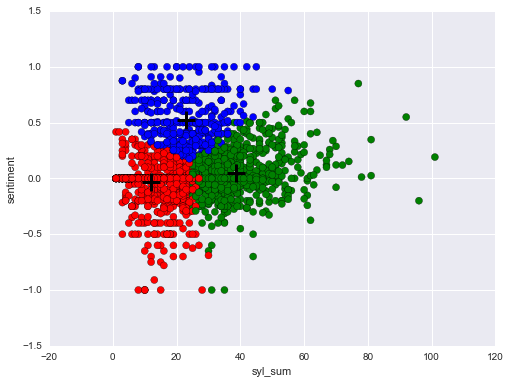

In [45]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df.syl_sum, df.sentiment, c=colors[df.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

In [46]:
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

0.44725660413364637

In [47]:
k_range = range(2,20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

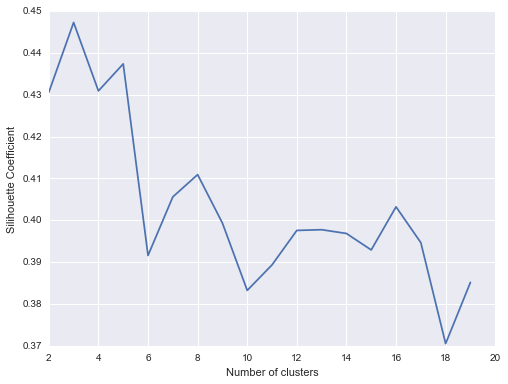

In [48]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette Coefficient')
plt.grid(True)

In [52]:
k_range = range(2,150)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

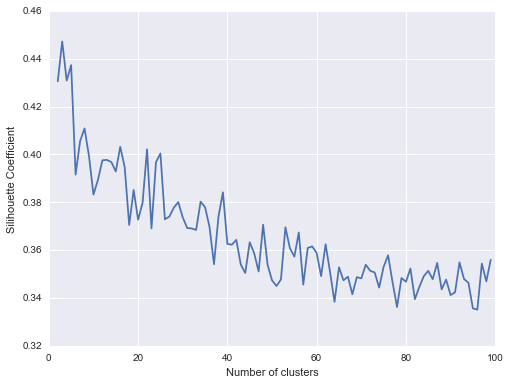

In [50]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette Coefficient')
plt.grid(True)

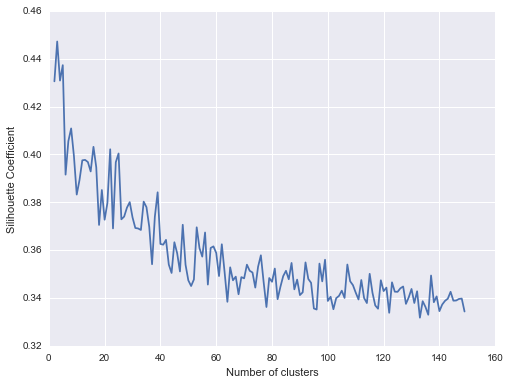

In [53]:
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silihouette Coefficient')
plt.grid(True)

In [55]:
cluster_0 = df[df['cluster'] ==0]
len(cluster_0)

1174

In [56]:
cluster_1 = df[df['cluster'] ==1]
len(cluster_1)

686

In [57]:
cluster_2 = df[df['cluster']==2]
len(cluster_2)

386

In [58]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [59]:
df['cluster'] = km.labels_

In [60]:
df.groupby('cluster').mean()

,char_length,syl_sum,sentiment
cluster,,,
0,133.562500,43.718750,0.667231
1,36.548951,11.513986,-0.015190
2,118.283951,36.506173,-0.220504
3,39.114286,12.757143,0.770988
4,246.578947,75.421053,0.198808
5,57.831731,18.086538,-0.001329
6,113.578431,35.892157,0.316136
7,15.437018,4.683805,-0.001706
8,60.260870,19.869565,-0.795870


In [61]:
centers = df.groupby('cluster').mean()

In [62]:
colors = np.array(['#999999', '#0000ff', '#4d4d4d', '#0000b2', '#8833ff', '#333333', '#4412b2', '#808080', '#33a3ff', '#124cb2', '#666666', '#39b54a','#21682b', '#64c1b5', '#2b6855', '#91c164', '#40682b', '#3fa9f5', '#7cc3f5','#badcf5'])

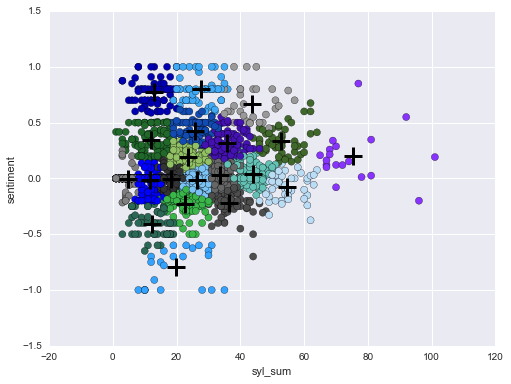

In [63]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df.syl_sum, df.sentiment, c=colors[df.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

In [64]:
df

,0,char_length,syl_sum,sentiment,cluster
0,The Wonderful Wizard of Oz by...,55,17,1.000000,3
1,The Cyclone 2.,11,3,0.000000,7
2,The Council with the Munchkins 3.,27,7,0.000000,7
3,How Dorothy Saved the Scarecrow 4.,28,9,0.000000,1
4,The Road Through the Forest 5.,24,6,0.000000,7
5,The Rescue of the Tin Woodman 6.,25,7,0.000000,7
6,The Cowardly Lion 7.,16,5,0.000000,7
7,The Journey to the Great Oz 8.,23,8,0.800000,3
8,The Deadly Poppy Field 9.,20,8,-0.200000,7
9,The Queen of the Field Mice 10.,24,7,0.000000,7


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118beb490>]], dtype=object)

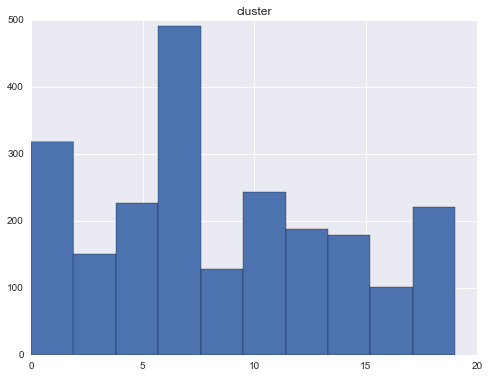

In [65]:
df.hist('cluster')

cluster
0     Axes(0.125,0.125;0.775x0.775)
1     Axes(0.125,0.125;0.775x0.775)
2     Axes(0.125,0.125;0.775x0.775)
3     Axes(0.125,0.125;0.775x0.775)
4     Axes(0.125,0.125;0.775x0.775)
5     Axes(0.125,0.125;0.775x0.775)
6     Axes(0.125,0.125;0.775x0.775)
7     Axes(0.125,0.125;0.775x0.775)
8     Axes(0.125,0.125;0.775x0.775)
9     Axes(0.125,0.125;0.775x0.775)
10    Axes(0.125,0.125;0.775x0.775)
11    Axes(0.125,0.125;0.775x0.775)
12    Axes(0.125,0.125;0.775x0.775)
13    Axes(0.125,0.125;0.775x0.775)
14    Axes(0.125,0.125;0.775x0.775)
15    Axes(0.125,0.125;0.775x0.775)
16    Axes(0.125,0.125;0.775x0.775)
17    Axes(0.125,0.125;0.775x0.775)
18    Axes(0.125,0.125;0.775x0.775)
19    Axes(0.125,0.125;0.775x0.775)
dtype: object

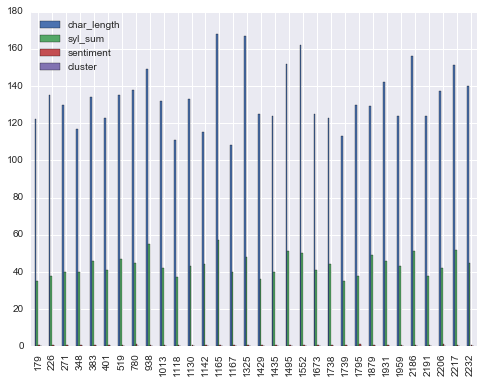

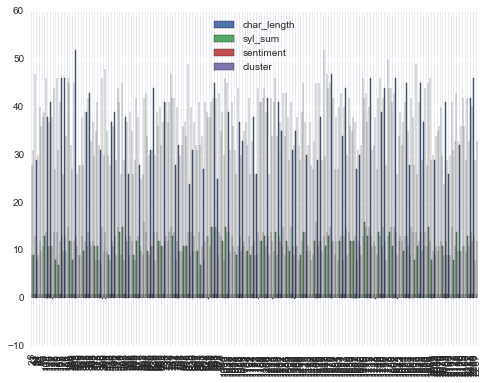

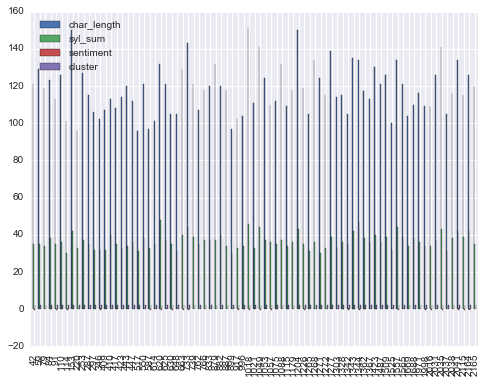

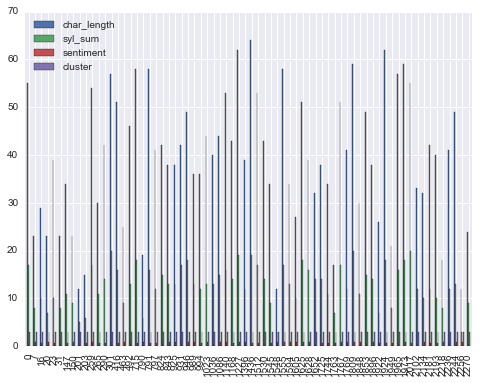

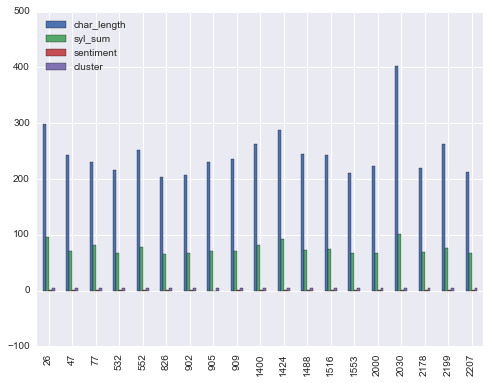

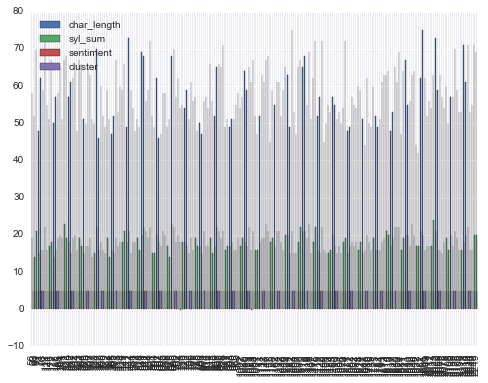

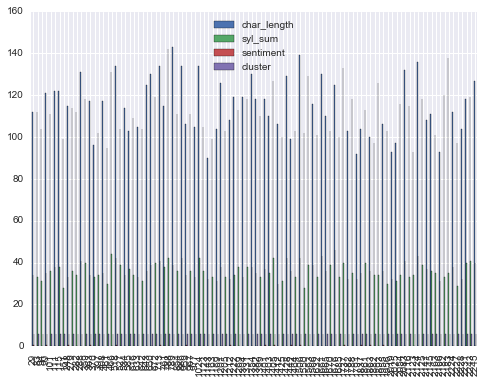

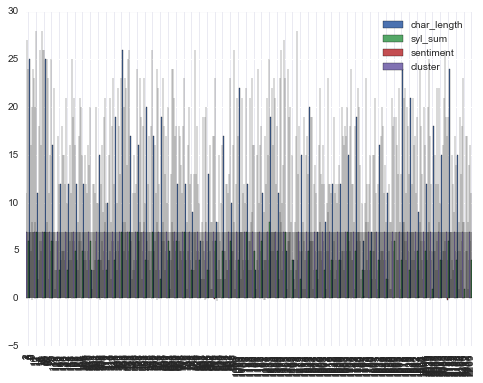

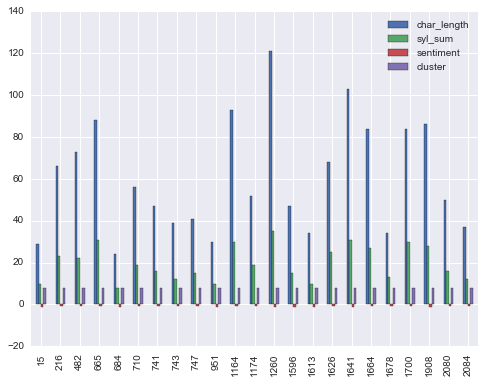

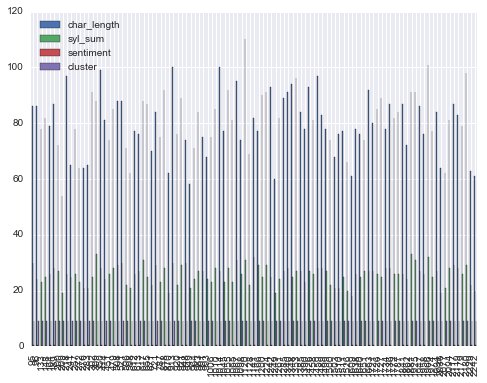

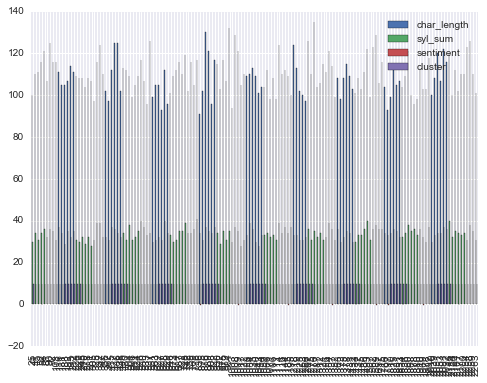

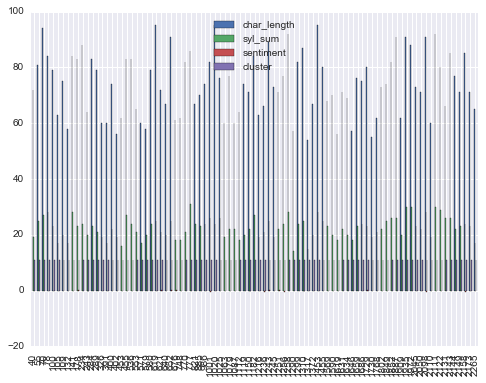

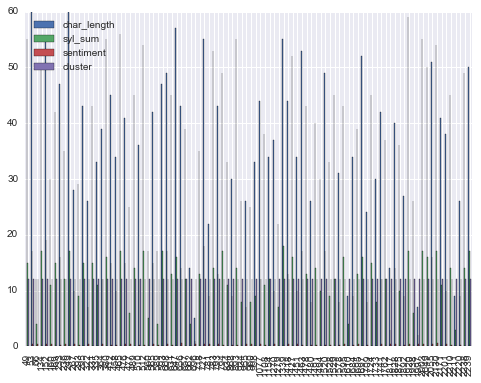

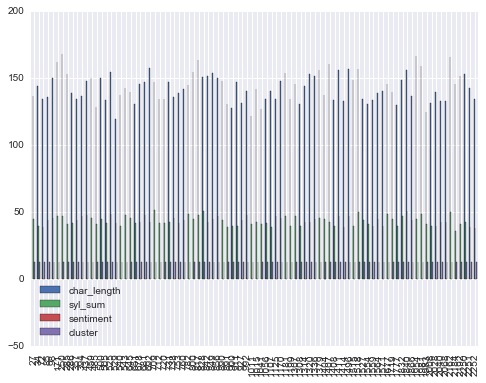

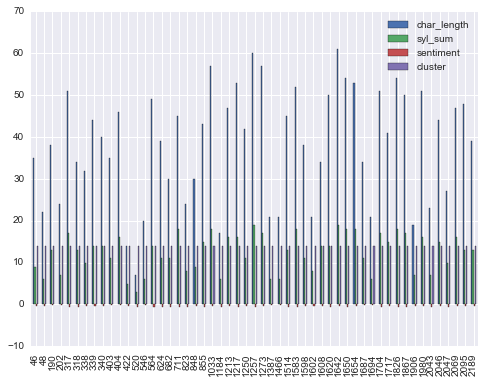

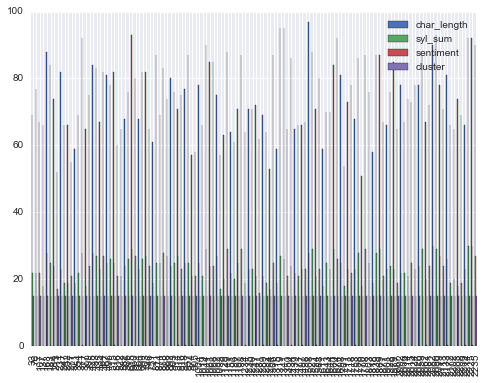

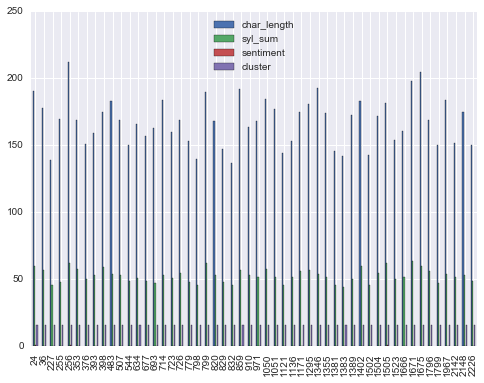

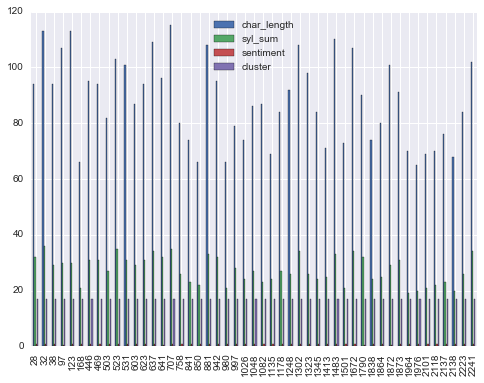

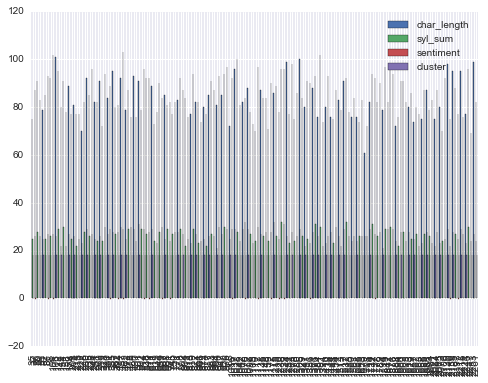

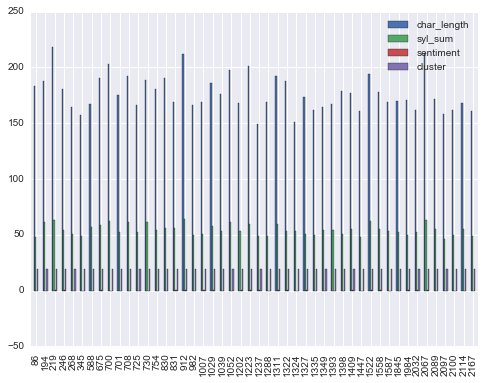

In [70]:
df.groupby('cluster').plot(kind='bar')

In [82]:
df3 = df.groupby('cluster').mean()

In [72]:
df3

,char_length,syl_sum,sentiment
cluster,,,
0,133.562500,43.718750,0.667231
1,36.548951,11.513986,-0.015190
2,118.283951,36.506173,-0.220504
3,39.114286,12.757143,0.770988
4,246.578947,75.421053,0.198808
5,57.831731,18.086538,-0.001329
6,113.578431,35.892157,0.316136
7,15.437018,4.683805,-0.001706
8,60.260870,19.869565,-0.795870


In [78]:
t = df[:98].groupby('cluster').mean()

In [ ]:
# what is the distribution of clusters across 

In [85]:
c0 = df[df['cluster']==0]

In [87]:
len(c0)

32

In [91]:
for x in c0['0']:
    print x
    print '*******'

"The Witch of the East was proud of those silver shoes," said one of the Munchkins, "and there is some charm connected with them; but what it is we never knew."
*******
Dorothy went to get him, and saw such delicious fruit hanging from the branches that she gathered some of it, finding it just what she wanted to help out her breakfast.
*******
She ate a hearty breakfast, and watched a wee Munchkin baby, who played with Toto and pulled his tail and crowed and laughed in a way that greatly amused Dorothy.
*******
It never hurt him, however, and Dorothy would pick him up and set him upon his feet again, while he joined her in laughing merrily at his own mishap.
*******
I had the fun of watching them make my body and my arms and legs; and when they fastened on my head, at last, I felt very proud, for I thought I was just as good a man as anyone.
*******
By good luck you came along and pulled me off the stake, and from what you say I am sure the Great Oz will give me brains as soon as we ge

In [92]:
c19=df[df['cluster'] ==19]

In [93]:
len(c19)

48

In [95]:
for x in c19['0']:
    print x
    print '******'

At first she had wondered if she would be dashed to pieces when the house fell again; but as the hours passed and nothing terrible happened, she stopped worrying and resolved to wait calmly and see what the future would bring.
******
At once the cap changed to a slate, on which was written in big, white chalk marks:    "LET DOROTHY GO TO THE CITY OF EMERALDS"   The little old woman took the slate from her nose, and having read the words on it, asked, "Is your name Dorothy, my dear?"
******
The Witch gave Dorothy a friendly little nod, whirled around on her left heel three times, and straightway disappeared, much to the surprise of little Toto, who barked after her loudly enough when she had gone, because he had been afraid even to growl while she stood by.
******
The sun shone bright and the birds sang sweetly, and Dorothy did not feel nearly so bad as you might think a little girl would who had been suddenly whisked away from her own country and set down in the midst of a strange land

In [96]:
c8 = df[df['cluster'] ==8]
len(c8)

23

In [97]:
for x in c8['0']:
    print x
    print'***'

The Discovery of Oz the Terrible   16.
***
When you get to Oz do not be afraid of him, but tell your story and ask him to help you.
***
"For," he said, "if I should get caught in the rain, and rust again, I would need the oil-can badly."
***
"I am terribly afraid of falling, myself," said the Cowardly Lion, "but I suppose there is nothing to do but try it.
***
"They must be dreadful beasts."
***
Those creatures frightened me so badly that my heart is beating yet."
***
he called after them, and they were very sorry to leave him.
***
Of course this was a bad thing for the Scarecrow.
***
I am afraid I shall never have any brains, after all!"
***
"Why do you wish to see the terrible Oz?"
***
So the Tin Woodman was forced to return sorrowfully to his friends and tell them of the terrible Beast he had seen.
***
And the Lion answered, "I am a Cowardly Lion, afraid of everything.
***
When the Wicked Witch looked out again and saw all her crows lying in a heap, she got into a terrible rage, and

In [98]:
c7 = df[df['cluster']==7]
len(c7)

389

In [100]:
for x in c7['0']:
    print x
    print '***'

The Cyclone    2.
***
The Council with the Munchkins    3.
***
The Road Through the Forest    5.
***
The Rescue of the Tin Woodman    6.
***
The Cowardly Lion    7.
***
The Deadly Poppy Field    9.
***
The Queen of the Field Mice   10.
***
The Guardian of the Gates   11.
***
The Emerald City of Oz   12.
***
The Search for the Wicked Witch   13.
***
The Rescue   14.
***
The Winged Monkeys   15.
***
How the Balloon Was Launched   18.
***
Away to the South   19.
***
Attacked by the Fighting Trees   20.
***
The Country of the Quadlings   23.
***
L. Frank Baum  Chicago, April, 1900.
***
Aunt Em was washing the dishes.
***
Suddenly Uncle Henry stood up.
***
"I'll go look after the stock."
***
she screamed.
***
"Run for the cellar!"
***
Then a strange thing happened.
***
Toto did not like it.
***
I have not killed anything."
***
See!"
***
"Oh, dear!
***
Oh, dear!"
***
Whatever shall we do?"
***
"But who was she?"
***
asked Dorothy.
***
"Who are the Munchkins?"
***
inquired Dorothy.
***
"Are y

In [ ]:
#create a loop to get the len of each cluster
#look at the counts of each cluster in the twenty pieces of the novel to see if there is a pattern

run two more stories like this to see if this analysis will work on them. then create a csv file with the twenty clusters as columns, find clusters with the other novels. 

In [107]:
for x in range(0,20):
    print len(df[df['cluster'] == x])

32
286
81
70
19
208
102
389
23
105
152
91
96
92
53
126
52
49
172
48


In [108]:
df3

,char_length,syl_sum,sentiment
cluster,,,
0,133.562500,43.718750,0.667231
1,36.548951,11.513986,-0.015190
2,118.283951,36.506173,-0.220504
3,39.114286,12.757143,0.770988
4,246.578947,75.421053,0.198808
5,57.831731,18.086538,-0.001329
6,113.578431,35.892157,0.316136
7,15.437018,4.683805,-0.001706
8,60.260870,19.869565,-0.795870


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14a5274d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14b185050>]], dtype=object)

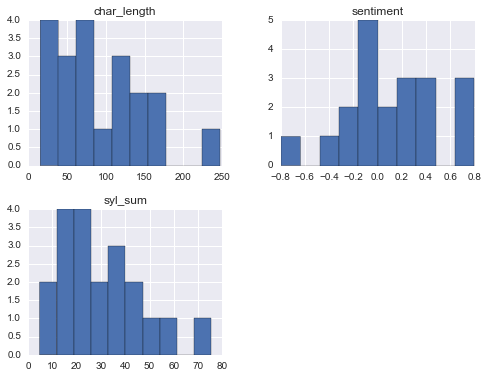

In [112]:
df3.hist()

In [114]:
c_1 = df[df['cluster'] ==1]
for x in c_1['0']:
    print x
    print '****'

How Dorothy Saved the Scarecrow    4.
****
The Lion Becomes the King of Beasts   22.
****
When Aunt Em came there to live she was a young, pretty wife.
****
The sun and wind had changed her, too.
****
Today, however, they were not playing.
****
"There's a cyclone coming, Em," he called to his wife.
****
Aunt Em dropped her work and came to the door.
****
One glance told her of the danger close at hand.
****
Dorothy felt as if she were going up in a balloon.
****
Three were men and one a woman, and all were oddly dressed.
****
But the little woman was doubtless much older.
****
Dorothy listened to this speech with wonder.
****
she continued, pointing to the corner of the house.
****
Dorothy looked, and gave a little cry of fright.
****
cried Dorothy, clasping her hands together in dismay.
****
"The house must have fallen on her.
****
"There is nothing to be done," said the little woman calmly.
****
"Yes, indeed," answered the little woman.
****
"She is my aunt who lives in Kansas, where

In [115]:
c_12 = df[df['cluster']==12]
for x in c_12['0']:
    print x
    print '***'
    

He worked hard from morning till night and did not know what joy was.
***
Toto played all day long, and Dorothy played with him, and loved him dearly.
***
"Quick, Dorothy!"
***
Now they are all set free, and are grateful to you for the favor."
***
I know this is true, for I am one of them myself, and cannot be mistaken.
***
But tell me, is it a civilized country?"
***
"He is more powerful than all the rest of us together.
***
"They surely will never do for a long journey, Toto," she said.
***
"I wonder if they will fit me," she said to Toto.
***
Evidently the Munchkins were good farmers and able to raise large crops.
***
So we know you are a friendly witch."
***
"Certainly," answered the Scarecrow.
***
"I'm pretty well, thank you," replied Dorothy politely.
***
"That is true," said the Scarecrow.
***
Toto did not like this addition to the party at first.
***
"Oh, I'm not afraid," replied the Scarecrow.
***
It is fortunate for Kansas that you have brains."
***
And when the second eye wa

In [118]:
df.describe()

,char_length,syl_sum,sentiment,cluster
count,2246.000000,2246.000000,2246.000000,2246.000000
mean,70.777382,22.098842,0.083963,8.642921
std,47.003287,14.554560,0.275489,5.443683
min,3.000000,1.000000,-1.000000,0.000000
25%,33.000000,11.000000,0.000000,5.000000
50%,64.500000,20.000000,0.000000,7.000000
75%,100.000000,31.000000,0.200000,13.000000
max,403.000000,101.000000,1.000000,19.000000


In [120]:
df.cluster.value_counts()

7     389
1     286
5     208
18    172
10    152
15    126
9     105
6     102
12     96
13     92
11     91
2      81
3      70
14     53
16     52
17     49
19     48
0      32
8      23
4      19
Name: cluster, dtype: int64

In [124]:
df[:98].cluster.value_counts()

7     24
1      9
18     8
10     8
5      6
3      6
13     5
2      5
11     4
17     4
12     3
6      3
4      3
15     2
14     2
16     2
9      2
8      1
19     1
Name: cluster, dtype: int64

In [138]:
s = df[:98].cluster.value_counts()
type(s)

pandas.core.series.Series

In [157]:
t = df.cluster.value_counts()
s = df[:98].cluster.value_counts()
for x in range(1,20):
    if s[x]:
        print s[x]
        

9
5
6
3
6
3
24
1
2
8
4
3
5
2
2
2
4
8
1


In [159]:
t = df.cluster.value_counts()
s = df[:98].cluster.value_counts()
w = s/t

In [160]:
w

0          NaN
1     0.031469
2     0.061728
3     0.085714
4     0.157895
5     0.028846
6     0.029412
7     0.061697
8     0.043478
9     0.019048
10    0.052632
11    0.043956
12    0.031250
13    0.054348
14    0.037736
15    0.015873
16    0.038462
17    0.081633
18    0.046512
19    0.020833
Name: cluster, dtype: float64

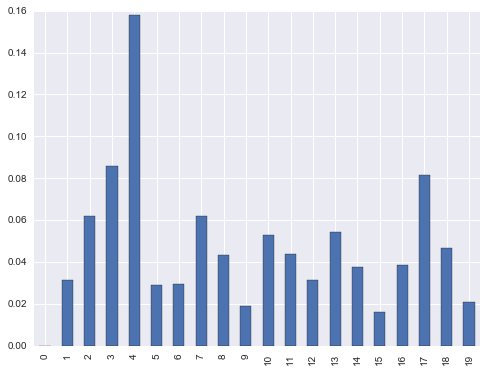

In [163]:
w.plot(kind='bar')

In [164]:
s2 = df[98:220].cluster.value_counts()

In [165]:
s2

7     32
1     17
18    11
5     10
9      7
10     7
15     6
11     6
6      5
2      4
3      4
12     4
19     2
14     2
17     2
8      1
13     1
0      1
Name: cluster, dtype: int64

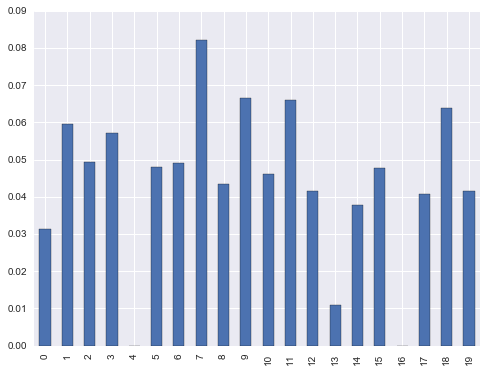

In [166]:
w2= s2/t
w2.plot(kind='bar')

Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


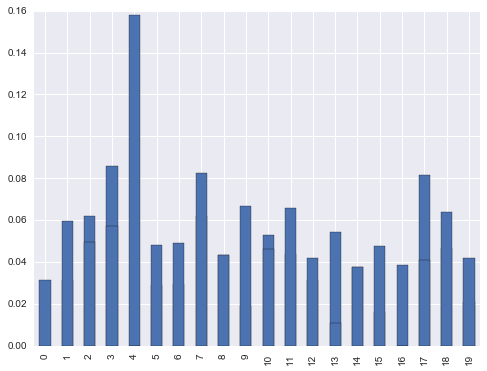

In [168]:
w.plot(kind='bar')
w2.plot(kind='bar')

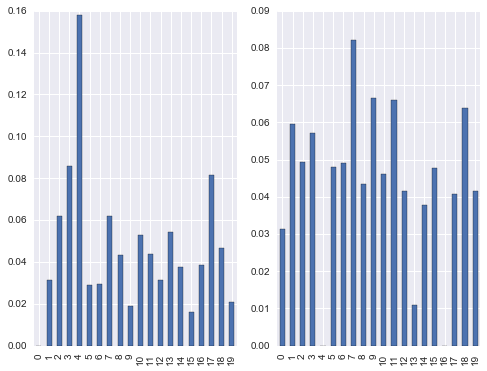

In [181]:
fig, axs = plt.subplots(1,2)

w.plot(kind='bar', ax=axs[0])
w2.plot(kind='bar', ax=axs[1])

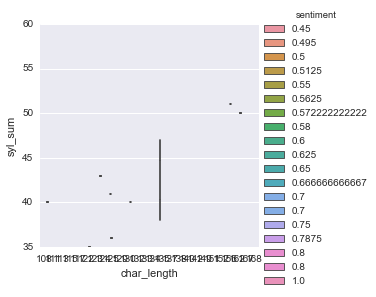

In [185]:
sns.factorplot(
    hue='sentiment',
    x='char_length',
    y='syl_sum',
    data=df[df.cluster==0],
    kind='box' 
)


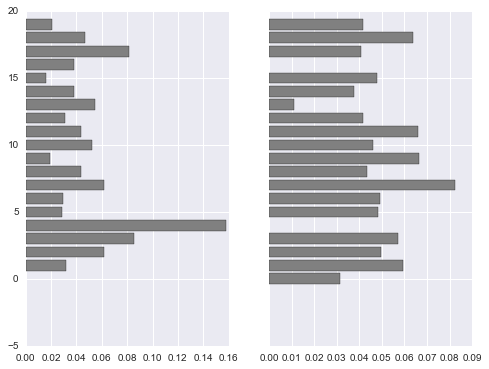

In [190]:
y = w.index
x1 = w
x2 = w2
fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(y, x1, align='center', color='gray')
axes[1].barh(y, x2, align='center', color='gray')
#axes[0].invert_xaxis()
plt.show()

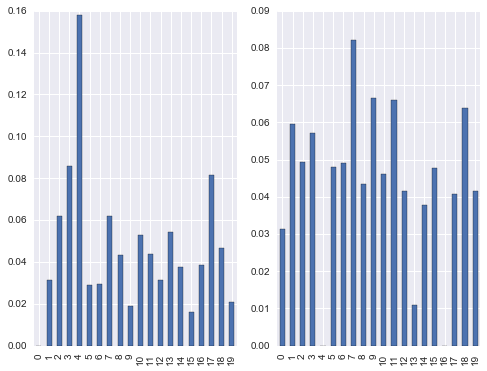

In [195]:
fig, axs = plt.subplots(1,2)

w.plot(kind='bar', ax=axs[0])
w2.plot(kind='bar', ax=axs[1])

In [197]:
x = (0.,10,0.1)
a = cos(x)
b = sin(x)
c = exp(x/10)
d = exp(-x/10)
la = plt.plot(x,a,'b-',label='cosine')
lb = plt.plot(x,b,'r--',label='sine')
lc = plt.plot(x,c,'gx',label='exp(+x)')
ld = plt.plot(x,d,'y-', linewidth = 5,label='exp(-x)')
ll = plt.legend(loc='upper left')
lx = plt.xlabel('xaxis')
ly = plt.ylabel('yaxis')
plt.show()
 


NameError: name 'cos' is not defined

In [199]:
w

0          NaN
1     0.031469
2     0.061728
3     0.085714
4     0.157895
5     0.028846
6     0.029412
7     0.061697
8     0.043478
9     0.019048
10    0.052632
11    0.043956
12    0.031250
13    0.054348
14    0.037736
15    0.015873
16    0.038462
17    0.081633
18    0.046512
19    0.020833
Name: cluster, dtype: float64

[None, None, None, None, None]

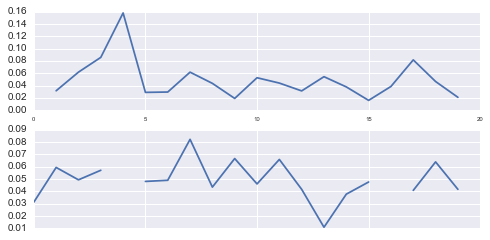

In [202]:
t = range(20)
s1 = w
s2 = w2

ax1 = plt.subplot(311)
plt.plot(t, s1)
plt.setp(ax1.get_xticklabels(), fontsize=6)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t, s2)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)


for now see if i can compare the twenty piece sentiment pattern & the 20 cluster pattern to other novels. I could possibly add all of these together to make 90 columns. that way I would be comparing clusters, sentiment pattern through the time, and syl_sum, and char_length as well through the time of the novel to see which one's are similar. I could then also see how those compare to the topic clustering, 

In [208]:
# DBSCAN with eps=1 and min_samples=3
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1, min_samples=3)
db.fit(X_scaled)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

In [209]:
db.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [211]:
df5 = df.copy(deep=True)

In [212]:
df5.head()

,0,char_length,syl_sum,sentiment,cluster
0,The Wonderful Wizard of Oz by...,55,17,1.0,3
1,The Cyclone 2.,11,3,0.0,7
2,The Council with the Munchkins 3.,27,7,0.0,7
3,How Dorothy Saved the Scarecrow 4.,28,9,0.0,1
4,The Road Through the Forest 5.,24,6,0.0,7


In [213]:
df5['cluster'] = db.labels_
df5.sort_values('cluster')

,0,char_length,syl_sum,sentiment,cluster
2199,Glinda The Good Witch Grants Dorothy's Wish ...,263,77,0.850000,-1
26,"Yet the old time fairy tale, having served for...",298,96,-0.200000,-1
1424,"Finding they were determined to go, the Winkie...",288,92,0.550000,-1
2030,"There were milkmaids and shepherdesses, with b...",403,101,0.191204,-1
1515,She had all the Winged Monkeys brought before ...,149,40,0.250000,0
1514,"""The princess was angry, and she knew, of cour...",45,13,-0.500000,0
1513,But when Gayelette came running out to him she...,79,22,0.000000,0
1517,This Cap had been made for a wedding present t...,91,29,-0.083333,0
1506,"""My grandfather was at that time the King of t...",139,42,0.420000,0
1518,Of course my grandfather and all the other Mon...,157,50,0.087500,0


In [214]:
df5.groupby('cluster').mean()

,char_length,syl_sum,sentiment
cluster,,,
-1,313.000000,91.500000,0.347801
0,70.301027,21.962483,0.084944
1,103.333333,31.333333,-1.000000


In [219]:
#scatter plot matrix of DBSCAN cluster assignments (0=red, 1=green, 2=blue, -1=yellow)
pd.scatter_matrix(X, c=colors[df5.cluster], figsize=(10,10), s=100)

TypeError: list indices must be integers, not Series

In [220]:
type(X)

pandas.core.frame.DataFrame

In [221]:
type(df5.cluster)

pandas.core.series.Series

In [222]:
## calculate SC this model
db = DBSCAN(eps=1, min_samples=3)
db.fit(X_scaled)
metrics.silhouette_score(X_scaled, db.labels_)

0.49696949167997495

In [225]:
## calculate SC this model
db = DBSCAN(eps=1, min_samples=2)
db.fit(X_scaled)
metrics.silhouette_score(X_scaled, db.labels_)

0.49696949167997495

In [223]:
db = DBSCAN(eps=1, min_samples=5)
db.fit(X_scaled)
metrics.silhouette_score(X_scaled, db.labels_)

0.64466570181817417

In [224]:
# Find the parameters with the lowest silhouette_score
for x in range (100,300):
    eps_val = x/100.0
    for min_samples_val in range(2,5):
        db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        db.fit(X_scaled)
        print "eps=",eps_val,"min_samples=", min_samples_val, "   silhouette_score=",metrics.silhouette_score(X_scaled, db.labels_)
        
         

eps= 1.0 min_samples= 2    silhouette_score= 0.49696949168
eps= 1.0 min_samples= 3    silhouette_score= 0.49696949168
eps= 1.0 min_samples= 4    silhouette_score= 0.644665701818
eps= 1.01 min_samples= 2    silhouette_score= 0.49696949168
eps= 1.01 min_samples= 3    silhouette_score= 0.49696949168
eps= 1.01 min_samples= 4    silhouette_score= 0.644665701818
eps= 1.02 min_samples= 2    silhouette_score= 0.49696949168
eps= 1.02 min_samples= 3    silhouette_score= 0.49696949168
eps= 1.02 min_samples= 4    silhouette_score= 0.644665701818
eps= 1.03 min_samples= 2    silhouette_score= 0.49696949168
eps= 1.03 min_samples= 3    silhouette_score= 0.49696949168
eps= 1.03 min_samples= 4    silhouette_score= 0.644665701818
eps= 1.04 min_samples= 2    silhouette_score= 0.49696949168
eps= 1.04 min_samples= 3    silhouette_score= 0.49696949168
eps= 1.04 min_samples= 4    silhouette_score= 0.644665701818
eps= 1.05 min_samples= 2    silhouette_score= 0.49696949168
eps= 1.05 min_samples= 3    silhouette

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [227]:
for x in df3:
    print x

char_length
syl_sum
sentiment


In [239]:
df3

,char_length,syl_sum,sentiment
cluster,,,
0,133.562500,43.718750,0.667231
1,36.548951,11.513986,-0.015190
2,118.283951,36.506173,-0.220504
3,39.114286,12.757143,0.770988
4,246.578947,75.421053,0.198808
5,57.831731,18.086538,-0.001329
6,113.578431,35.892157,0.316136
7,15.437018,4.683805,-0.001706
8,60.260870,19.869565,-0.795870


In [238]:
df3['sentiment'][0]

0.66723090277777775

In [242]:
char_cl_0.append(df3['char_length'][0])

In [241]:
char_cl_0 = []


In [247]:
t = char_cl_0
t

[133.5625]

In [249]:
df_cluster_novel = pd.Series(t)

In [250]:
df_cluster_novel

0    133.5625
dtype: float64

In [275]:
df_cluster_novel = pd.Series(sent_cl_0, syl_cl_0, char_cl_0)

TypeError: int() argument must be a string or a number, not 'list'

In [271]:
df_cluster_novel

133.5625    43.71875
dtype: float64

In [258]:
syl_cl_0 = []
syl_cl_0.append(df3['syl_sum'][0])

In [259]:
syl_cl_0

[43.71875]

In [266]:
df_cluster_novel['syl_cl_0'] = syl_cl_0

In [267]:
df_cluster_novel

0              133.562
syl_cl_0    [43.71875]
dtype: object

In [272]:
sent_cl_0 = []
sent_cl_0.append(df3['sentiment'][0])

In [273]:
sent_cl_0

[0.66723090277777775]

In [278]:
t = df3['char_length'][0]

In [285]:
type(t)

numpy.float64

In [281]:
t2 = df3['syl_sum'][0]

In [284]:
type(t2)

numpy.float64

In [295]:
df_cluster_novel = pd.Series(syl_cl_0, char_cl_0 )

In [292]:
df_cluster_novel

43.71875    0.667231
dtype: float64

In [303]:
index = range(20)
columns = ['A','B', 'C']
df_ = pd.DataFrame(index=index, columns=columns)

In [308]:
df_

,A,B,C
0,1,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0


In [305]:
df_ = df_.fillna(0)

In [307]:
df_['A'][0] = 1

In [309]:
df_.to_csv('test.csv')